In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# collocation
import sys
import os
p_ = os.path.abspath(os.path.join('..', '00_utils'))
if p_ not in sys.path:
    sys.path.append(p_)
    
import collocation_obj
import importlib

In [65]:
def f(x):
    return x * np.sin(x)
    # return np.sin(x)

def df(x):
    return np.sin(x) + x*np.cos(x)
    # return np.cos(x)

eval_pt = np.linspace(0, 2*np.pi, 100)
f_values = f(eval_pt)
df_analytical = df(eval_pt)
df_numerical = np.gradient(f_values, eval_pt)
error = np.linalg.norm(df_analytical - df_numerical)

print("Maximum error:", np.max(error))

Maximum error: 0.09501322546375748


In [92]:
importlib.reload(collocation_obj)
Collocation = collocation_obj.Collocation

x_cheb = Collocation.chebyshev_nodes_second_kind(20, 0 , 10)

In [93]:
x_cheb

Array([ 0.        ,  0.06819348,  0.27091379,  0.60263124,  1.05429745,
        1.61359214,  2.26525921,  2.99152288,  3.77257256,  4.58710327,
        5.41289673,  6.22742744,  7.00847712,  7.73474079,  8.38640786,
        8.94570255,  9.39736876,  9.72908621,  9.93180652, 10.        ],      dtype=float64)

In [99]:
np.zeros_like(x)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

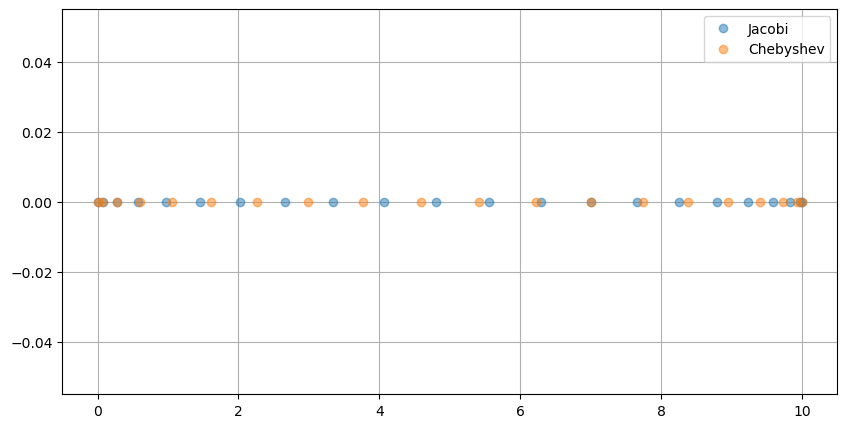

In [105]:
plt.figure(figsize=(10, 5))
plt.plot(x, np.zeros_like(x), 'o', label=f'Jacobi', alpha = 0.5)
plt.plot(x_cheb, np.zeros_like(x_cheb), 'o', label=f'Chebyshev', alpha = 0.5)
plt.grid()
plt.legend()
plt.show();


In [94]:
import numpy as np
from scipy.special import roots_jacobi

# https://scicomp.stackexchange.com/questions/32918/need-an-example-legendre-gauss-radau-pseudospectral-differentiation-matrix-or-ma
def OCnonsymGLReig(n, meth, a=0.0, b=1.0, include_endpoints=True):
    # meth = 1,2,3,4 for Gauss, Lobatto, Radau (right), Radau (left)
    na = [1, 0, 0, 1]  # Defines alpha offset for the weight formula
    nb = [1, 0, 1, 0]  # Defines beta offset for the weight formula
    nt = n + 2 if include_endpoints else n

    # Adjust alpha and beta based on the method
    alpha = 1.0 - na[meth-1]
    beta = 1.0 - nb[meth-1]

    # Get roots and weights for the Jacobi polynomial
    roots, weights = roots_jacobi(n, alpha, beta)

    # Define the transformation for the points from [-1, 1] to [a, b]
    x = 0.5 * (roots + 1)  # First transform to [0, 1]
    x = a + (b - a) * x  # Then scale to [a, b]
    
    if include_endpoints:
        x = np.hstack(([a], x, [b]))  # Include a and b as endpoints

    # Compute the first derivative matrix A
    xdif = x[:, np.newaxis] - x
    np.fill_diagonal(xdif, 1)  # Avoid division by zero
    dpx = np.prod(xdif, axis=1)

    A = dpx[:, np.newaxis] / (dpx * xdif)
    np.fill_diagonal(A, 1 - np.sum(A, axis=1))

    return x, A

# Usage Example
n = 20
meth = 4  # For example, using Gauss
x, A = OCnonsymGLReig(n, meth, a=0.0, b=10.0, include_endpoints=True)
print("Collocation points:", x)
print("First derivative matrix:\n", A)


Collocation points: [ 0.          0.08300044  0.27643053  0.57534458  0.97304128  1.46063247
  2.02722492  2.66016142  3.34530301  4.06734467  4.81015711  5.55714713
  6.29162819  6.99719323  7.65808114  8.25952887  8.78810133  9.23199163
  9.58128569  9.82818782  9.96723893 10.        ]
First derivative matrix:
 [[-2.21000000e+01  2.99555568e+01 -1.21103743e+01  7.02991319e+00
  -4.78801267e+00  3.57865013e+00 -2.84651552e+00  2.36992279e+00
  -2.04498718e+00  1.81750877e+00 -1.65707758e+00  1.54589001e+00
  -1.47349401e+00  1.43424928e+00 -1.42625241e+00  1.45134030e+00
  -1.51643248e+00  1.63765835e+00 -1.85278576e+00  2.26860163e+00
  -3.37335932e+00  2.10000000e+00]
 [-4.84575880e+00 -5.04184756e-02  6.96084142e+00 -3.30408655e+00
   2.10532342e+00 -1.52605139e+00  1.19374422e+00 -9.83881601e-01
   8.43420228e-01 -7.46230229e-01  6.78178949e-01 -6.31184396e-01
   6.00562209e-01 -5.83780010e-01  5.79924277e-01 -5.89654720e-01
   6.15724624e-01 -6.64641867e-01  7.51702481e-01 -9.202

In [83]:
dy_dt = []
for i in range(len(x)):
    dy_dt.append(A[i] @ f(x))

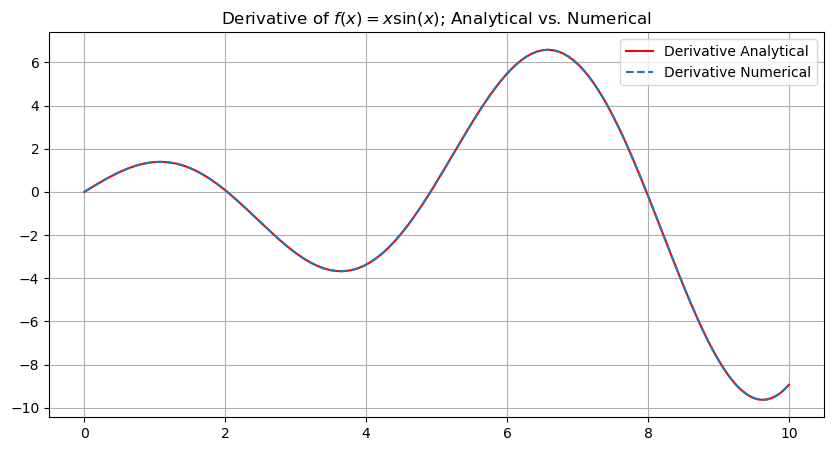

Maximum error: 0.09501322546375748


In [84]:
plt.figure(figsize=(10, 5))
plt.plot(x, df(x), color='red', label=f'Derivative Analytical')
plt.plot(x, dy_dt, '--', label=f'Derivative Numerical')
plt.title('Derivative of $f(x) = x \sin(x)$; Analytical vs. Numerical')
plt.grid()
plt.legend()
plt.show();

# error = np.mean((df(nodes) - dy_dt)**2)

print("Maximum error:", np.max(error))

## Regular Approach: Using all Nodes

In [37]:
import numpy as np
from scipy.special import roots_jacobi

def radau_left_points(n):
    # Alpha = 1, Beta = 0 for left Radau including x=-1
    alpha, beta = (1, 0)
    
    # Calculate roots of the Jacobi polynomial P_n^(alpha, beta)
    # This function returns the roots and weights, we only take the roots
    roots, _ = roots_jacobi(n, alpha, beta)
    
    # Ensure that -1 is added if not already included (due to numerical precision issues)
    if -1 not in roots:
        roots = np.append(roots, -1)
    
    # The roots should already be sorted, but we can ensure this:
    roots = np.sort(roots)
    
    return roots

# Example usage
n = 20  # Degree of the polynomial
radau_points = radau_left_points(n)
print("Left Radau Points from -1 to 1:", radau_points)

Left Radau Points from -1 to 1: [-1.         -0.99344779 -0.96563756 -0.91625714 -0.84639833 -0.75762027
 -0.65190577 -0.53161623 -0.39943865 -0.25832564 -0.11142943  0.03796858
  0.18653107  0.3309394   0.46796772  0.59455502  0.70787351  0.80539174
  0.88493108  0.94471389  0.98339991]


In [38]:
importlib.reload(collocation_obj)
Collocation = collocation_obj.Collocation

D = Collocation.derivative_matrix_gauss_radau_legendre(radau_points)
dy_dt = []
for i in range(len(radau_points)):
    dy_dt.append(D[i] @ f(radau_points))

In [39]:
D[0]

array([-1.10000000e+02, -5.11474883e+03,  6.37707004e+02, -2.03107043e+02,
        9.08695042e+01, -4.83188826e+01,  2.84434969e+01, -1.78580682e+01,
        1.16927050e+01, -7.86432056e+00,  5.37267357e+00, -3.69383216e+00,
        2.53407435e+00, -1.71950417e+00,  1.14244072e+00, -7.33631412e-01,
        4.47039029e-01, -2.51099803e-01,  1.23455525e-01, -4.75854164e-02,
        1.04046606e-02])

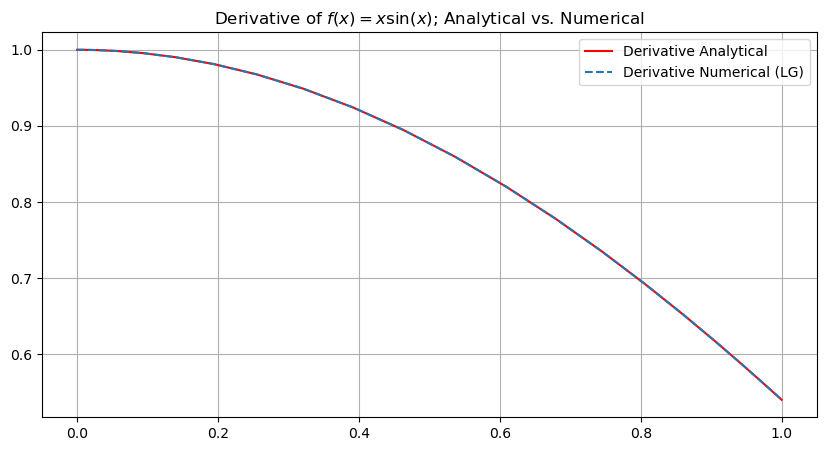

Maximum error: 0.004769757712245246


----

In [199]:
# this approach involves re-computing the nodes and derivative matrix
gl_collocation_16 = Collocation(16, 0, 6, 'gauss_legendre')

nodes_16 = gl_collocation_16.compute_nodes()
D_16 = gl_collocation_16.compute_derivative_matrix()

dy_dt_16 = []
nodes_filtered_16 = []
for i in range(len(nodes_16)):
    nodes_filtered_16.append(nodes_16[i])
    dy_dt_16.append(D_16[i] @ f(nodes_16))

In [200]:
n = gl_collocation.compute_nodes()

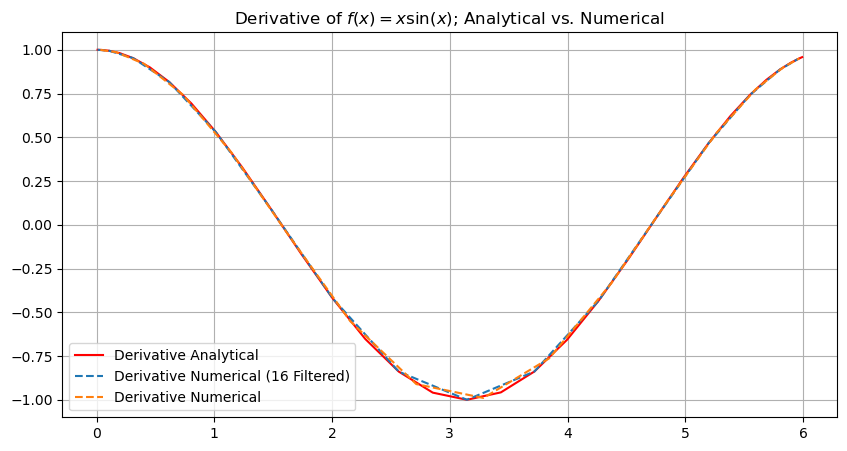

Maximum error: 0.004769757712245246


In [201]:
plt.figure(figsize=(10, 5))
plt.plot(n, df(n), color='red', label=f'Derivative Analytical')
plt.plot(nodes_filtered, dy_dt, '--', label=f'Derivative Numerical (16 Filtered)')
plt.plot(nodes_16, dy_dt_16, '--',label=f'Derivative Numerical')
plt.title('Derivative of $f(x) = x \sin(x)$; Analytical vs. Numerical')
plt.grid()
plt.legend()
plt.show();

# error = np.mean((df(nodes) - dy_dt)**2)

print("Maximum error:", np.max(error))